# Assignment5
- Rewrite the MNIST LSTM code using your own LSTM layer. You are not allowed to use nn.LSTM or nn.LSTMCell!, but you can use nn.Linear
- Classify Fashion-MNIST using the following models:
    - PyTorch LSTM model (using nn.LSTM)
    - Your own LSTM
- Extra point:
    - Extra point to write MNIST GRU code using your own GRU layer (Don't use nn.GRU or nn.GRUCell!)

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as Functions
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time
import pandas as pd
import PIL
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Helpers

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
''' Move tensors to cuda/chosen device , dataloader to move data to chosen device'''
def move_to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [move_to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield move_to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [ ]:
class Helpers(object):
    def accuracy(self, target_label, predicted_label):

        _, prediction = torch.max(predicted_label, dim=1)
        acc = torch.sum(prediction == target_label).item() / len(prediction)
        return torch.tensor(acc)

    def confusion_matrix(self, model, test_data_loader):

        cm = np.zeros([10,10])
        with torch.no_grad():
            for images, labels in test_data_loader:
                predictions = model(images)
                maxPreds, preds = torch.max(predictions, dim=1)
                for idx, label in enumerate(labels):
                    cm[label.item(), preds[idx].item()] += 1 
        return cm

    def plot_the_curves(self, epochs, train_loss, train_accu, val_loss, val_accu):

        plt.style.use('seaborn')
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(20,5)

        ax[0].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
        ax[0].plot(epochs, val_loss, c="blue", label="Val Loss", linewidth=3)
        ax[0].legend(loc="best")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("CE Loss")
        ax[0].set_title("Loss Curves")

        ax[1].plot(epochs, train_accu, c="red", label="Train accuracy", linewidth=3)
        ax[1].plot(epochs, val_accu, c="blue", label="Val accuracy", linewidth=3)
        ax[1].legend(loc="best")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Accuracy (%)")
        ax[1].set_title(f"Accuracy Curves")

        plt.show()

    def show_grid(self, data, titles=None):
        '''code taken from the class material'''
        """Imshow for Tensor."""
        data = data.numpy().transpose((0, 2, 3, 1))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        data = std * data + mean
        data = np.clip(data, 0, 1)
        
        plt.figure(figsize=(8*2, 4*2))
        for i in range(32):
            plt.subplot(4,8,i+1)
            plt.imshow(data[i])
            plt.axis("off")
            if titles is not None:
                plt.title(titles[i])
        plt.tight_layout()
        plt.show()

In [ ]:
class Train_model():
    def __init__(self,
                 model,
                 loss_function,
                 optimizer,
                 scheduler,
                 val_data_loader,
                 train_data_loader,
                 epochs=10):
        
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.val_data_loader = val_data_loader
        self.train_data_loader = train_data_loader
        self.epochs = epochs

    def train(self, input_image, target_label):

        self.model.train()

        self.optimizer.zero_grad()
        output = self.model(input_image)
        loss = self.loss_function(output, target_label)
        loss.backward()
        self.optimizer.step()
        train_acc = Helpers().accuracy(target_label, output)

        return loss.item(), train_acc

    def evaluate(self, data_loader):

        val_loss = []
        val_accu = []

        self.model.eval()
        with torch.no_grad():
            for image, label in data_loader:
                output = self.model(image)
                val_loss.append(self.loss_function(output, label))
                val_accu.append(Helpers().accuracy(label, output))

        val_loss = torch.stack(val_loss).mean()
        val_accu = torch.stack(val_accu).mean()

        return val_loss.item(), val_accu.item()

    def model_fit(self):

        val_loss = []
        val_accu = []
        train_loss = []
        train_accu = []

        epochs = []

        print(f"Training started")
        print(f"\n")

        for i in range(self.epochs):
            train_loss_iter = []
            train_accu_iter = []
            for image, label in self.train_data_loader:
                loss, accu = self.train(image, label)
                train_loss_iter.append(loss)
                train_accu_iter.append(accu)

            v_loss, v_accu = self.evaluate(self.val_data_loader)
            val_loss.append(v_loss)
            val_accu.append(v_accu)
            epochs.append(i)

            self.scheduler.step()
            train_loss.append(np.mean(train_loss_iter))
            train_accu.append(np.mean(train_accu_iter))

            if i % 5 == 0 or i == self.epochs-1:
                print(f"Epoch {i+1}/{self.epochs}:")
                print(f"    Train loss: {np.round(np.mean(train_loss_iter), 2)}")
                print(f"    Train accuracy: {np.round(np.mean(train_accu_iter), 2)*100}%")
                print(f"    Val loss: {np.round(v_loss, 2)}")
                print(f"    Val accuracy: {np.round(v_accu, 2)*100}%")
                print(f"\n")

        print(f"Training completed!")

        return epochs, train_loss, train_accu, val_loss, val_accu

In [ ]:
#code usesd from the lecture
import os
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

# LSTM Models

Image taken from https://www.ais.uni-bonn.de/SS21/VisionSystems/Material/Session%205/Lab%20Vision_%20RNNs.pdf

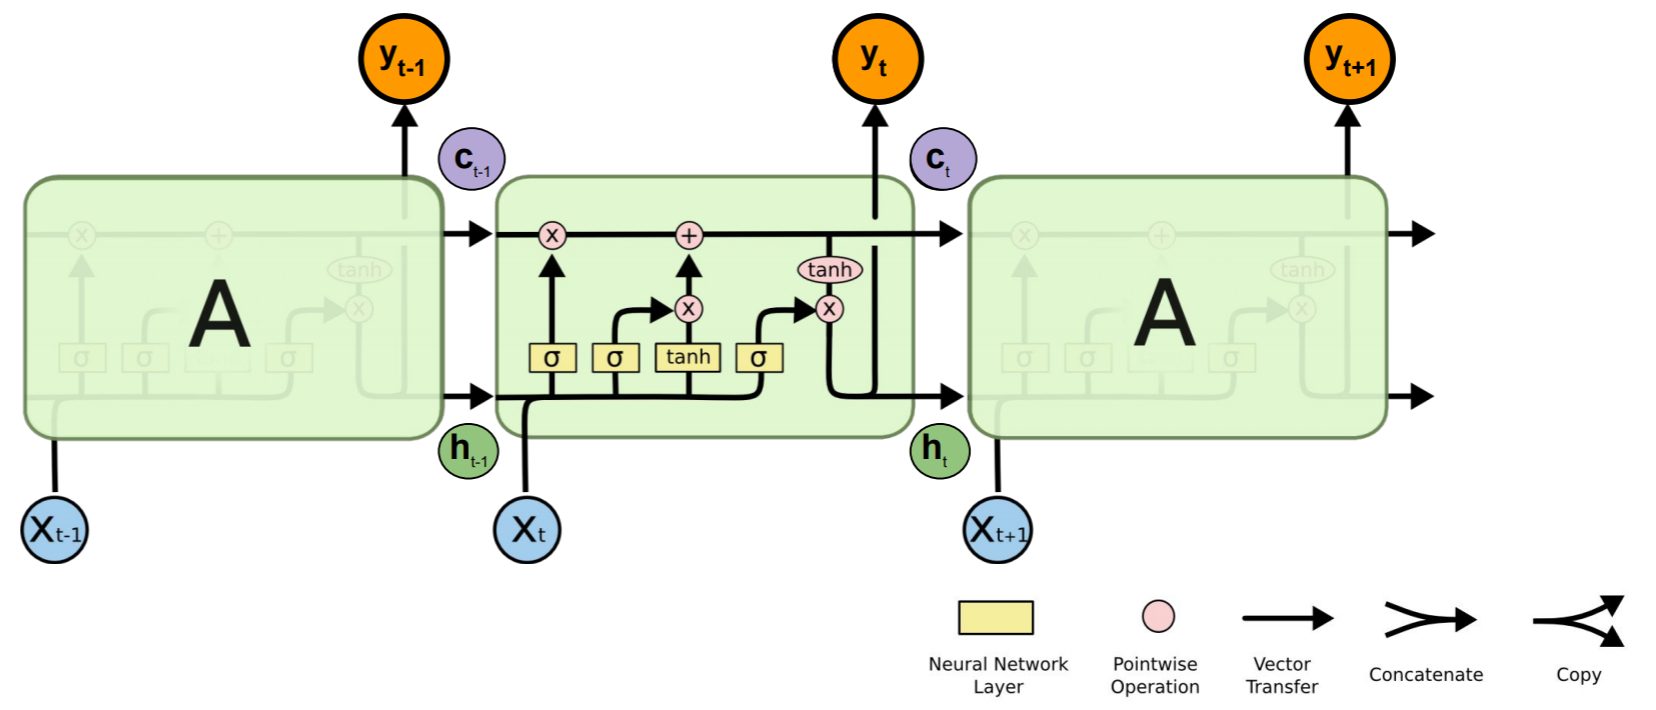

In [ ]:
class My_LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(My_LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.linear1 = nn.Linear(in_features=self.input_size, out_features=4*self.hidden_size, bias=self.bias)
        self.linear2 = nn.Linear(in_features=self.hidden_size, out_features=4*self.hidden_size, bias=self.bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for param in self.parameters():
            param.data.uniform_(-std, std)

    def forward(self, input_image, h_t_x, c_t_x):

        x_rowed = input_image.view(-1, input_image.size(1))
        all_gates = self.linear1(x_rowed) + self.linear2(h_t_x)
        all_gates = all_gates.squeeze()

        f_t, i_t, c_t, o_t = all_gates.chunk(4,1)

        f_t = torch.sigmoid(f_t)
        i_t = torch.sigmoid(i_t)
        c_t = torch.tanh(c_t)
        o_t = torch.sigmoid(o_t)

        c_t_out = torch.multiply(f_t, c_t_x) + torch.multiply(i_t, c_t)
        h_t_out = torch.multiply(o_t, torch.tanh(c_t_out))

        return h_t_out, c_t_out

In [ ]:
class My_LSTM_Model(nn.Module):

    def __init__(self, input_image, hidden_size, layer_dimension, output_dimension, bias=True):
        super(My_LSTM_Model, self).__init__()
        self.input_image = input_image
        self.hidden_size = hidden_size
        self.layer_dimension = layer_dimension
        self.output_dimension = output_dimension
        self.bias = bias
        self.lstm = My_LSTM(self.input_image, self.hidden_size, self.layer_dimension)
        self.classifier = nn.Linear(in_features=self.hidden_size, out_features=self.output_dimension)

    def forward(self, image):

        image = image.view(-1, 28, 28)
        h_t_x = torch.zeros(self.layer_dimension, image.shape[0], self.hidden_size)
        c_t_x = torch.zeros(self.layer_dimension, image.shape[0], self.hidden_size)

        h_t_x = move_to_device(h_t_x, device)
        c_t_x = move_to_device(c_t_x, device)

        output = []
        h_t_x = h_t_x[0,:,:]
        c_t_x = c_t_x[0,:,:]

        for step in range(image.shape[1]):
            for layer in range(self.layer_dimension):
                h_t, c_t = self.lstm(image[:,step,:], h_t_x, c_t_x)
                output.append(h_t)
                h_t_x = h_t
                c_t_x = c_t

        output_last_layer = output[-1].squeeze()
        classifier_output = self.classifier(output_last_layer)

        return classifier_output

# MNIST LSTM

In [ ]:
set_random_seed()

train_dataset= dsets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset= dsets.MNIST(root='./data',train=False,transform=transforms.ToTensor(),download=True)

B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

device = get_default_device()

train_data_loader = DeviceDataLoader(train_loader, device)
test_data_loader = DeviceDataLoader(test_loader, device)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



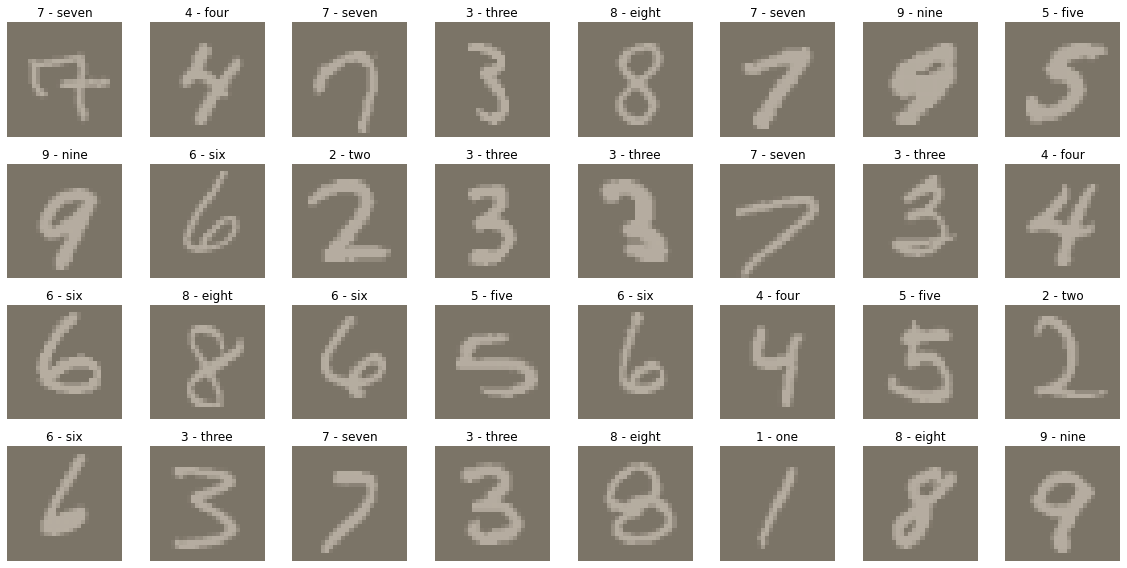

In [ ]:
# Get a batch of training data and displaying it
class_names = train_dataset.classes
inputs, classes = next(iter(train_loader))
titles = [class_names[x] for x in classes]

Helpers().show_grid(inputs, titles=titles)

In [ ]:
inputs.shape

torch.Size([256, 1, 28, 28])

In [ ]:
test_in = torch.zeros_like(inputs)

test_in[:, 0] = 1
test_in[:, 15:] = inputs[:, 15:]
test_in

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        ...,


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1.

In [ ]:
input_dim = 28
hidden_dim = 128
layer_dim = 2  
output_dim = 10

model = My_LSTM_Model(input_dim, hidden_dim, layer_dim, output_dim)
model = move_to_device(model, device)
loss_function = Functions.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.2)
epoch = 10

model_fit = Train_model(model,
                        loss_function,
                        optimizer,
                        scheduler,
                        test_data_loader,
                        train_data_loader,
                        epochs=epoch)

torch.cuda.empty_cache()
epochs, train_loss, train_accu, val_loss, val_accu = model_fit.model_fit()

Training started


Epoch 1/10:
    Train loss: 1.68
    Train accuracy: 40.99999964237213%
    Val loss: 0.93
    Val accuracy: 70.0%


Epoch 6/10:
    Train loss: 0.18
    Train accuracy: 94.9999988079071%
    Val loss: 0.18
    Val accuracy: 95.0%


Epoch 10/10:
    Train loss: 0.15
    Train accuracy: 95.99999785423279%
    Val loss: 0.15
    Val accuracy: 96.0%


Training completed!


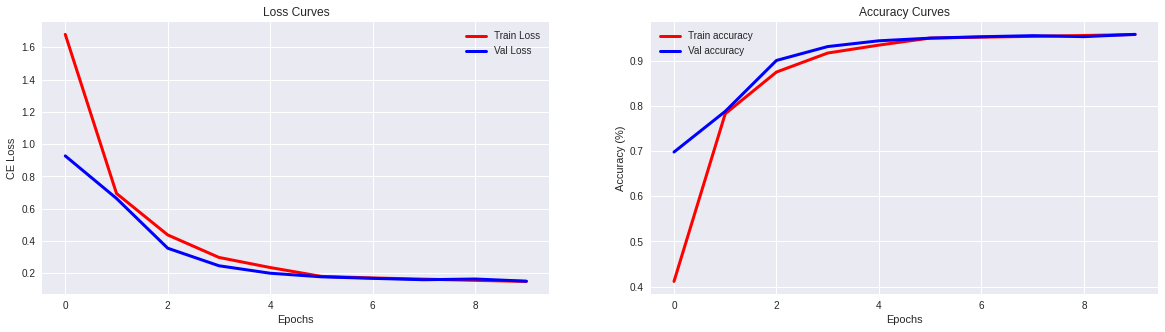

In [ ]:
Helpers().plot_the_curves(epochs, train_loss, train_accu, val_loss, val_accu)

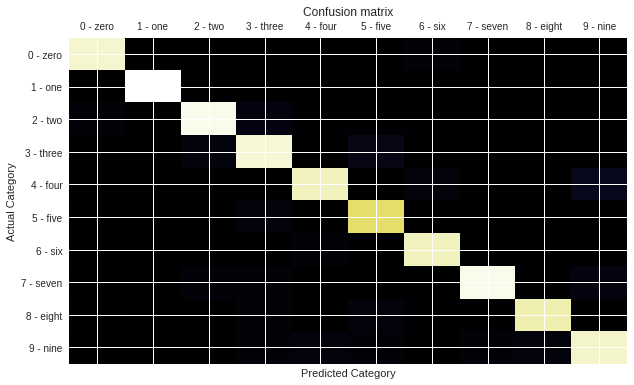

In [ ]:
cm = Helpers().confusion_matrix(model, test_data_loader)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(10), train_dataset.classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), train_dataset.classes)
plt.show()

From above results we could see that the LSTM model from pytorch (results in class material) and the lstm model from scratch (as seen above), perform relatively similar, except that the pytorch model performs almost around 1-2% better than the above lstm model. 

# MNIST Fashion - Pytorch LSTM

In [ ]:
# Pytorch LSTM model, taken from class material
class SequentialClassifier(nn.Module):
    """ 
    Sequential classifier for images. Embedded image rows are fed to a RNN
    
    Args:
    -----
    input_dim: integer
        dimensionality of the rows to embed
    emb_dim: integer 
        dimensionality of the vectors fed to the LSTM
    hidden_dim: integer
        dimensionality of the states in the cell
    num_layers: integer
        number of stacked LSTMS
    mode: string
        intialization of the states
    """
    
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random", "learned"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.num_layers = num_layers
        self.mode = mode
        if(mode == "learned"):
            self.learned_h = nn.Parameter(
                    torch.randn(num_layers, 1, hidden_dim).requires_grad_()
                )
            self.learned_c = nn.Parameter(
                    torch.randn(num_layers, 1, hidden_dim).requires_grad_()
                )
        
        # for embedding rows into vector representations
        self.encoder = nn.Linear(in_features=input_dim, out_features=emb_dim)
        # LSTM model
        self.lstm = nn.LSTM(
            input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True
        )
        # FC-classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)
        
        return
    
    
    def forward(self, x):
        """ Forward pass through model """
        
        b_size, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # embedding rows
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)
        embeddings = self.encoder(x_rowed)
        
        # feeding LSTM
        lstm_out, (h_out, c_out) = self.lstm(x_rowed, (h,c)) 
        
        # classifying
        y = self.classifier(lstm_out[:, -1, :])  # feeding only output at last layer
        
        return y
    
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "learned"):
            h = self.learned_h.repeat(1, b_size, 1)
            c = self.learned_c.repeat(1, b_size, 1)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [ ]:
set_random_seed()

train_dataset= dsets.FashionMNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset= dsets.FashionMNIST(root='./data',train=False,transform=transforms.ToTensor(),download=True)

B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

device = get_default_device()

train_data_loader = DeviceDataLoader(train_loader, device)
test_data_loader = DeviceDataLoader(test_loader, device)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



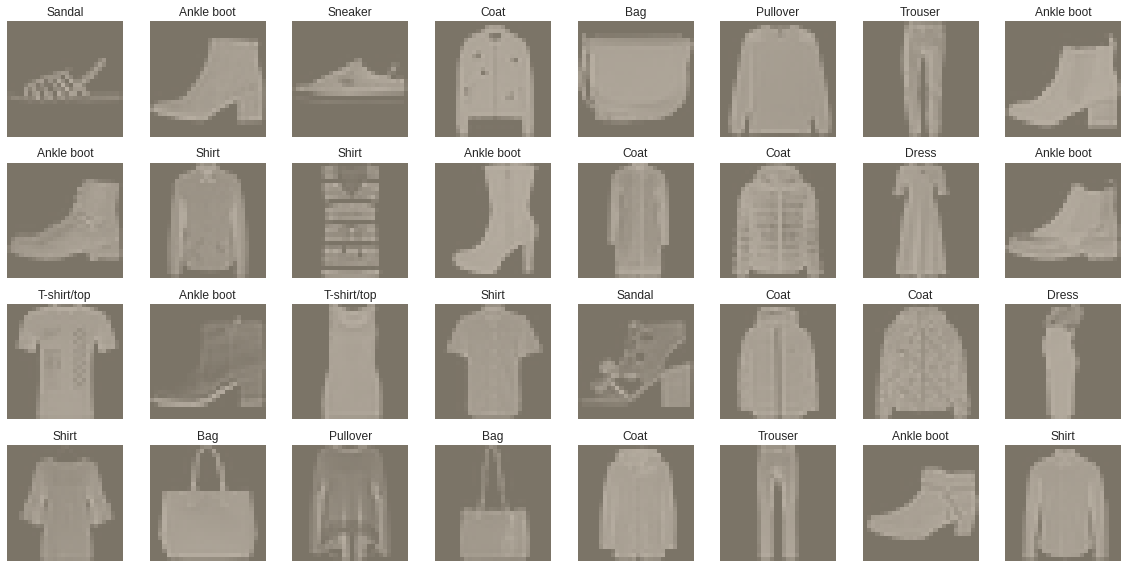

In [ ]:
# Get a batch of training data and displaying it
class_names = train_dataset.classes
inputs, classes = next(iter(train_loader))
titles = [class_names[x] for x in classes]

Helpers().show_grid(inputs, titles=titles)

In [ ]:
model = model = SequentialClassifier(input_dim=28, emb_dim=64, hidden_dim=128, num_layers=2, mode="zeros")
model = move_to_device(model, device)
loss_function = Functions.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.2)
epoch = 10

model_fit = Train_model(model,
                        loss_function,
                        optimizer,
                        scheduler,
                        test_data_loader,
                        train_data_loader,
                        epochs=epoch)

torch.cuda.empty_cache()
print(f"Training for MNIST Fashion data")
epochs, train_loss, train_accu, val_loss, val_accu = model_fit.model_fit()

Training for MNIST Fashion data
Training started


Epoch 1/10:
    Train loss: 1.17
    Train accuracy: 56.99999928474426%
    Val loss: 0.69
    Val accuracy: 74.0%


Epoch 6/10:
    Train loss: 0.41
    Train accuracy: 85.00000238418579%
    Val loss: 0.44
    Val accuracy: 84.0%


Epoch 10/10:
    Train loss: 0.39
    Train accuracy: 86.00000143051147%
    Val loss: 0.42
    Val accuracy: 84.0%


Training completed!


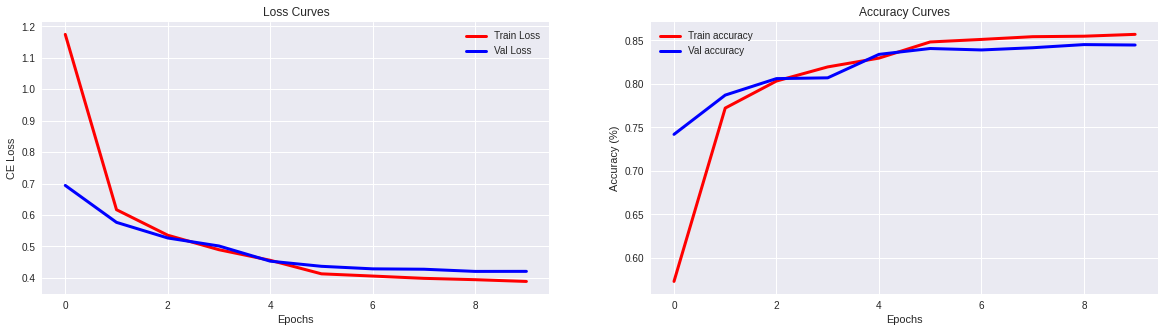

In [ ]:
Helpers().plot_the_curves(epochs, train_loss, train_accu, val_loss, val_accu)

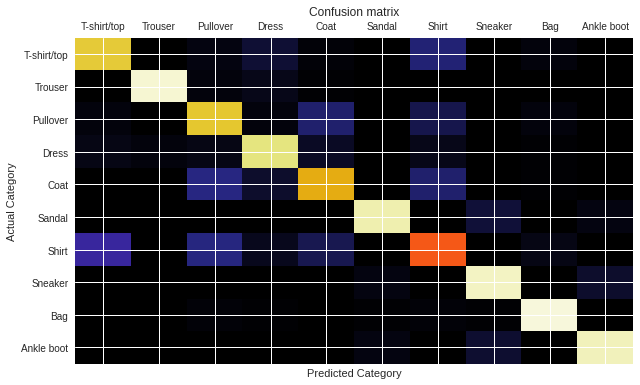

In [ ]:
cm = Helpers().confusion_matrix(model, test_data_loader)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(10), train_dataset.classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), train_dataset.classes)
plt.show()

We could see from above confusion matrix that the model gets confused with few of the objects like shitrs and t-shirts, pullover, coat.

#MNIST Fashion - Own LSTM

In [ ]:
input_dim = 28
hidden_dim = 128
layer_dim = 2  
output_dim = 10

model = My_LSTM_Model(input_dim, hidden_dim, layer_dim, output_dim)
model = move_to_device(model, device)
loss_function = Functions.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.2)
epoch = 10

model_fit = Train_model(model,
                        loss_function,
                        optimizer,
                        scheduler,
                        test_data_loader,
                        train_data_loader,
                        epochs=epoch)

torch.cuda.empty_cache()
print(f"Training with own LSTM model for MNIST Fashion data")
epochs, train_loss, train_accu, val_loss, val_accu = model_fit.model_fit()

Training with own LSTM model for MNIST Fashion data
Training started


Epoch 1/10:
    Train loss: 1.47
    Train accuracy: 44.999998807907104%
    Val loss: 0.94
    Val accuracy: 64.0%


Epoch 6/10:
    Train loss: 0.47
    Train accuracy: 82.99999833106995%
    Val loss: 0.48
    Val accuracy: 83.0%


Epoch 10/10:
    Train loss: 0.44
    Train accuracy: 83.99999737739563%
    Val loss: 0.46
    Val accuracy: 83.0%


Training completed!


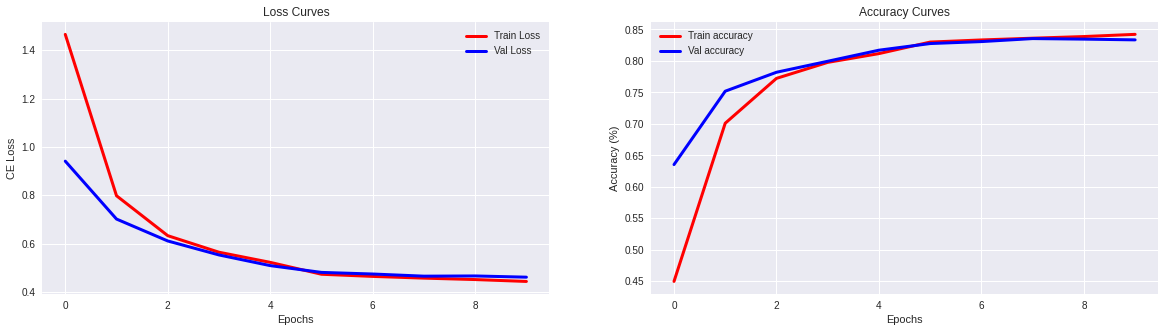

In [ ]:
Helpers().plot_the_curves(epochs, train_loss, train_accu, val_loss, val_accu)

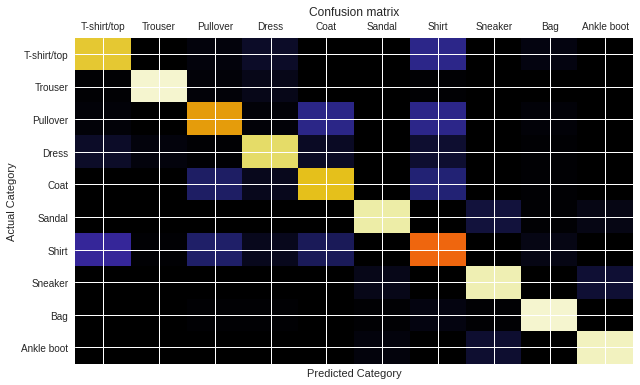

In [ ]:
cm = Helpers().confusion_matrix(model, test_data_loader)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(10), train_dataset.classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), train_dataset.classes)
plt.show()

From above model performances, we could see that both the models performs good on MNIST Fashion dataset. Even the LSTM model (own) gets confused between shirt, t-shirt, coat, and pullover. As seen above, both the models performs better and similar. 

#GRU

Image taken from https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

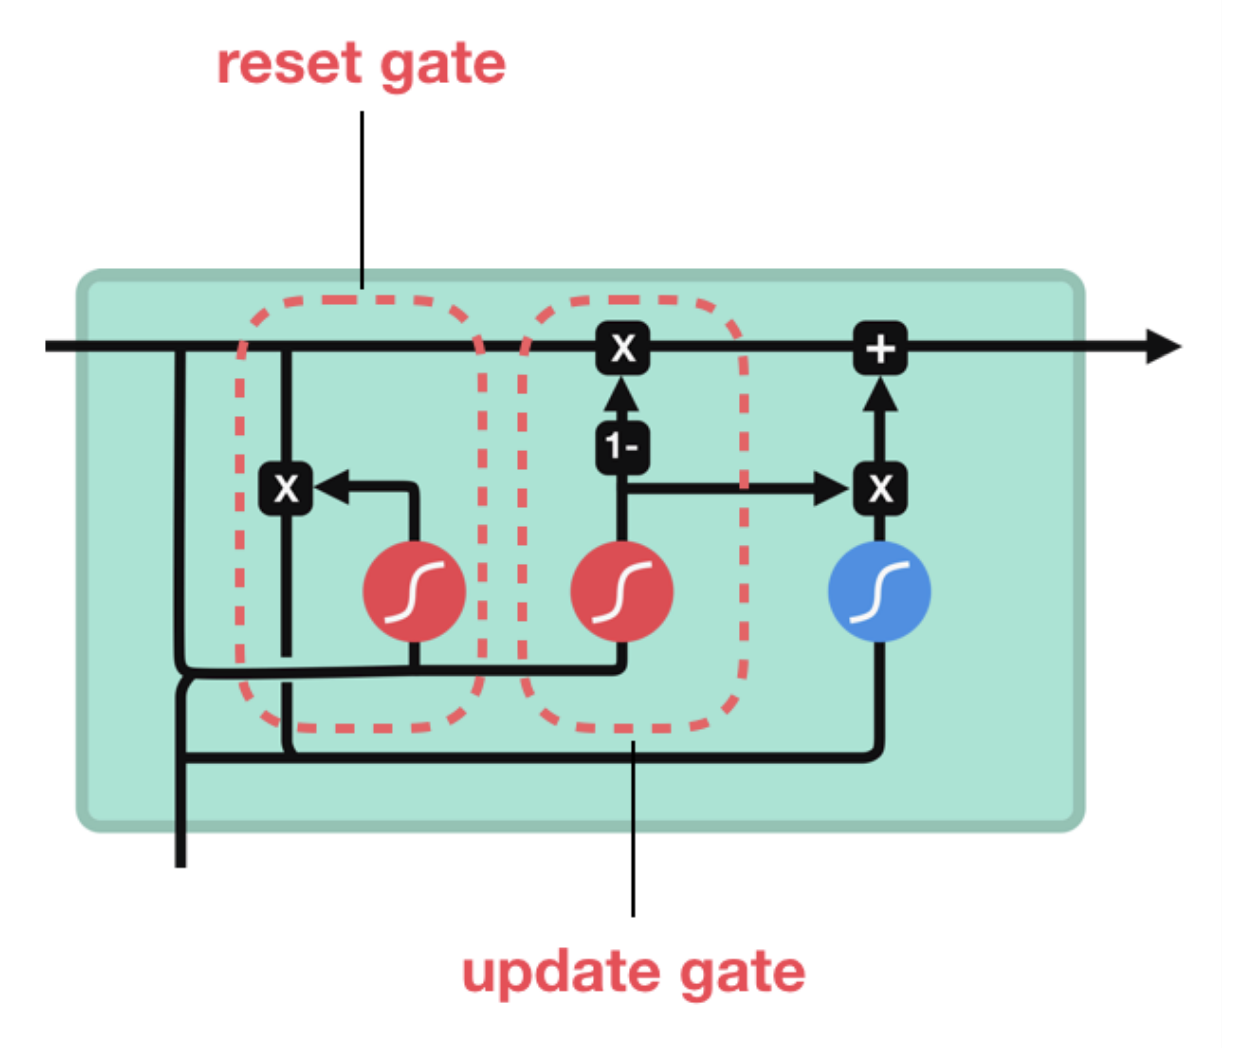

In [ ]:
class My_GRU(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(My_GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.linear1 = nn.Linear(in_features=self.input_size, out_features=3*self.hidden_size, bias=self.bias)
        self.linear2 = nn.Linear(in_features=self.hidden_size, out_features=3*self.hidden_size, bias=self.bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for param in self.parameters():
            param.data.uniform_(-std, std)

    def forward(self, input_image, h_t_x):

        x_rowed = input_image.view(-1, input_image.size(1))

        x_t = self.linear1(x_rowed)
        h_t = self.linear2(h_t_x)

        x_t = x_t.squeeze()
        h_t = h_t.squeeze()

        x_t_reset, x_t_update, x_t_new = x_t.chunk(3,1)
        h_t_reset, h_t_update, h_t_new = h_t.chunk(3,1)

        reset_gate = torch.sigmoid(x_t_reset + h_t_reset)
        update_gate = torch.sigmoid(x_t_update + h_t_update)
        new_gate = torch.tanh(x_t_new + torch.multiply(h_t_new, reset_gate))

        h_t_out = (torch.multiply(h_t_x, (1-update_gate))) + (torch.multiply(new_gate, update_gate))

        return h_t_out

In [ ]:
class My_GRU_Model(nn.Module):

    def __init__(self, input_image, hidden_size, layer_dimension, output_dimension, bias=True):
        super(My_GRU_Model, self).__init__()
        self.input_image = input_image
        self.hidden_size = hidden_size
        self.layer_dimension = layer_dimension
        self.output_dimension = output_dimension
        self.bias = bias
        self.lstm = My_GRU(self.input_image, self.hidden_size, self.layer_dimension)
        self.classifier = nn.Linear(in_features=self.hidden_size, out_features=self.output_dimension)

    def forward(self, image):

        image = image.view(-1, 28, 28)
        h_t_x = torch.zeros(self.layer_dimension, image.shape[0], self.hidden_size)

        h_t_x = move_to_device(h_t_x, device)

        output = []
        h_t_x = h_t_x[0,:,:]

        for step in range(image.shape[1]):
            for layer in range(self.layer_dimension):
                h_t = self.lstm(image[:,step,:], h_t_x)
                output.append(h_t)
                h_t_x = h_t

        output_last_layer = output[-1].squeeze()
        classifier_output = self.classifier(output_last_layer)

        return classifier_output

In [ ]:
set_random_seed()

train_dataset= dsets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset= dsets.MNIST(root='./data',train=False,transform=transforms.ToTensor(),download=True)

B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

device = get_default_device()

train_data_loader = DeviceDataLoader(train_loader, device)
test_data_loader = DeviceDataLoader(test_loader, device)

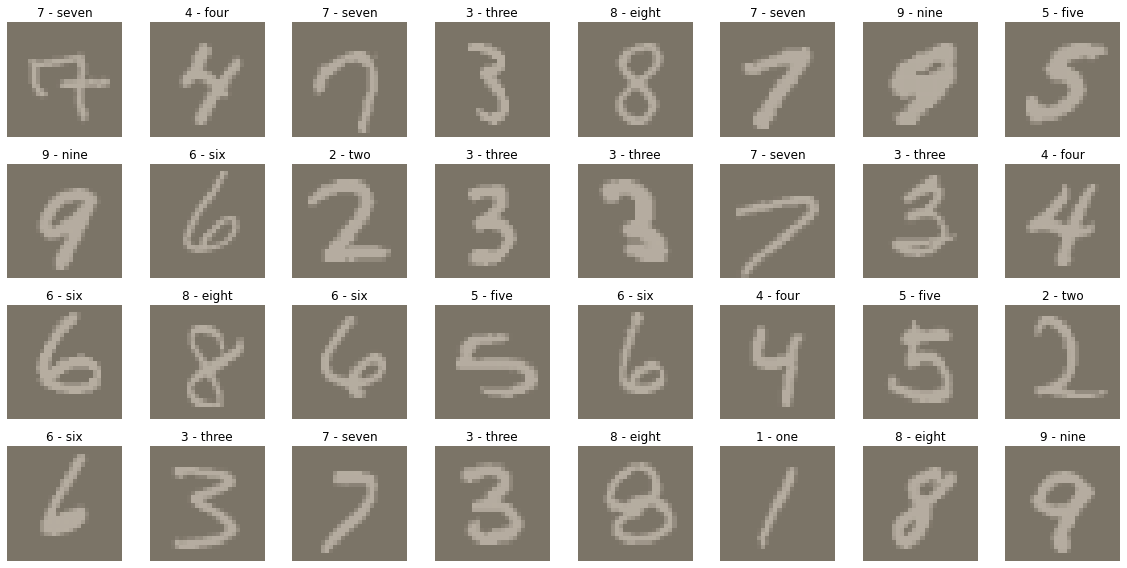

In [ ]:
# Get a batch of training data and displaying it
class_names = train_dataset.classes
inputs, classes = next(iter(train_loader))
titles = [class_names[x] for x in classes]

Helpers().show_grid(inputs, titles=titles)

In [ ]:
input_dim = 28
hidden_dim = 128
layer_dim = 2  
output_dim = 10

model = My_GRU_Model(input_dim, hidden_dim, layer_dim, output_dim)
model = move_to_device(model, device)
loss_function = Functions.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.2)
epoch = 10

model_fit = Train_model(model,
                        loss_function,
                        optimizer,
                        scheduler,
                        test_data_loader,
                        train_data_loader,
                        epochs=epoch)

torch.cuda.empty_cache()
epochs, train_loss, train_accu, val_loss, val_accu = model_fit.model_fit()

Training started


Epoch 1/10:
    Train loss: 1.72
    Train accuracy: 38.999998569488525%
    Val loss: 1.17
    Val accuracy: 59.0%


Epoch 6/10:
    Train loss: 0.66
    Train accuracy: 79.00000214576721%
    Val loss: 0.63
    Val accuracy: 79.0%


Epoch 10/10:
    Train loss: 0.58
    Train accuracy: 81.00000023841858%
    Val loss: 0.55
    Val accuracy: 82.0%


Training completed!


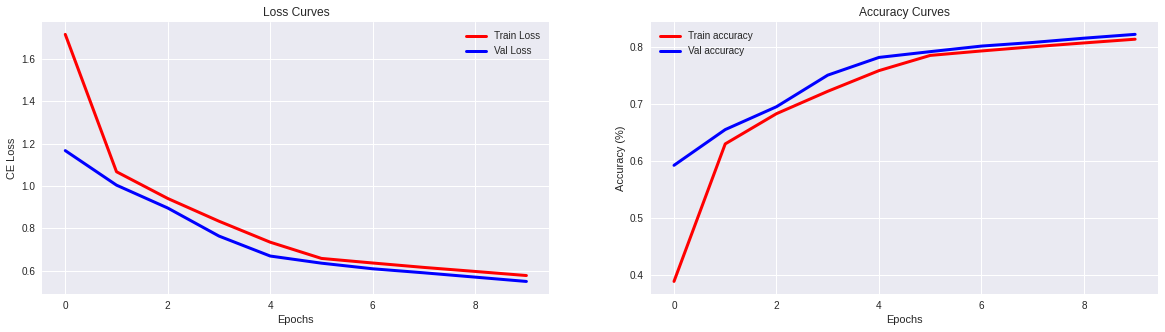

In [ ]:
Helpers().plot_the_curves(epochs, train_loss, train_accu, val_loss, val_accu)

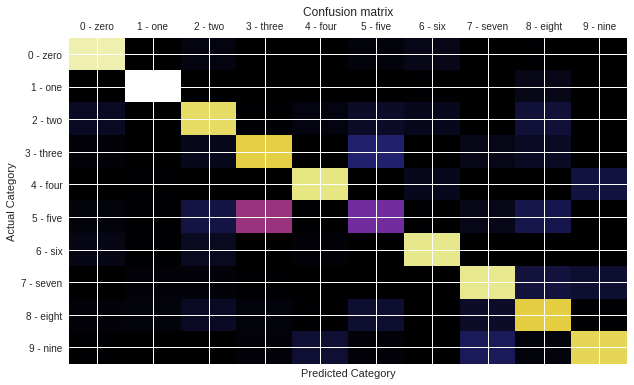

In [ ]:
cm = Helpers().confusion_matrix(model, test_data_loader)
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.matshow(cm, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('CMRmap'))
plt.title("Confusion matrix")
plt.ylabel('Actual Category')
plt.yticks(range(10), train_dataset.classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), train_dataset.classes)
plt.show()

From above we can see that the model converges near the 6th epoch or the training step and produces a validation accuracy of 82%. From confusion matrix we can see that the model mixes up few similar looking numbers such as three and five, eight and five, and so on. But may be my GRU implementation requires some tuning, or might require more training epochs to produce much accurate results. 